In [98]:
import numpy as np
import matplotlib.pyplot as plt
import random as rd
from scipy import constants
from scipy.linalg import lstsq
from matplotlib.animation import FuncAnimation
from matplotlib.animation import writers
import matplotlib.gridspec as gridspec
from Simbo import generate_levels, getrand, setzero, exchange, recdist, accum, calc_Eav
from Simbo import calc_Bolt_ent, calc_av_ent, calc_prob_temp, find_max, find_skips, plot_prob_temp

k_B = constants.value(u'Boltzmann constant')
h = constants.value(u'Planck constant')
c = constants.value(u'speed of light in vacuum')

<IPython.core.display.Javascript object>


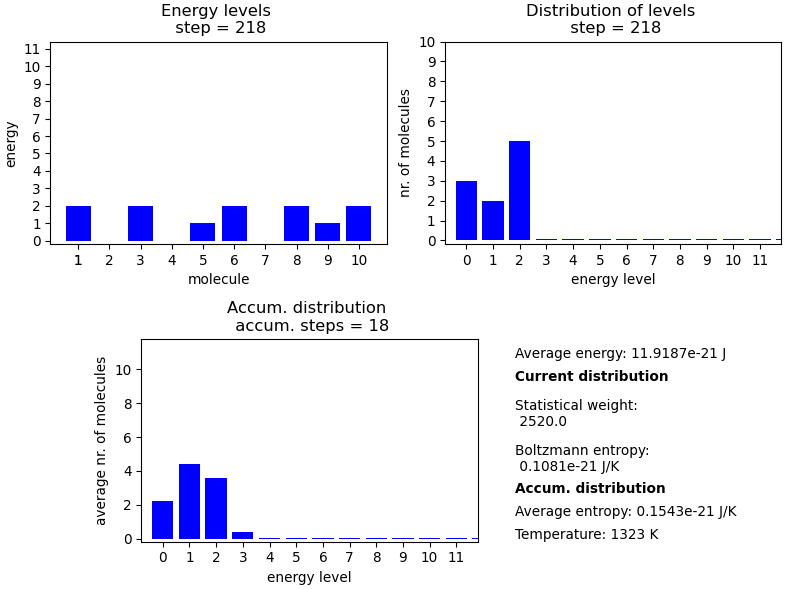

In [103]:
#run short simulation
%matplotlib notebook

nu = 500e2
nop = 10 ##user input
en = 2 ##user input

#initialize
istep = 0
nstot = 40*nop
nseqv = 20*nop

#automatic generation of levels
#levels = generate_levels(en, nop)
#manual input
levels = [12, 0, 0, 0, 0, 0, 0, 0, 0, 0]
maxlev, idist, dist_sum, nstep = setzero(levels)
      
#prepare graphs
fig = plt.figure(constrained_layout=True, figsize=(8, 6))
gs = fig.add_gridspec(2, 4)
gs.update(wspace=0.5)
ax1 = fig.add_subplot(gs[0, :2], )
ax2 = fig.add_subplot(gs[0, 2:])
ax3 = fig.add_subplot(gs[1, 1:3])
all_levels = []
all_distr = []
all_dist_sum = []
all_uav = []
all_wbolt = []
all_sw = []
all_sa = []
all_temp = []

zero_array = []

for i in range(int(sum(levels))+1):
    zero_array.append(0.05)

#run
while istep < nstot:
    
    bef = istep
    
    #get random molecules
    ifrom, ito = getrand(nop)
    
    #exchange energy
    levels, istep = exchange(ifrom, ito, nop, levels, istep)
    
    if istep > bef: #exchange not possible sometimes (level[ifrom] = 0)
        
        #calculate distribution over energy levels
        distr, all_levels, all_distr = recdist(nop, levels, maxlev, all_levels, all_distr)
    
        #calculate accumulated distribution
        if istep > nseqv: #check if equilibrated
            
            idist, dist_sum, all_dist_sum, nstep = accum(nop, maxlev, idist, distr, dist_sum, nstep, all_dist_sum)
            all_uav.append(calc_Eav(maxlev, distr, nop))#add to accum?
            W, S_w = calc_Bolt_ent(nop, distr)
            all_wbolt.append(W)
            all_sw.append(S_w)
            all_sa.append(calc_av_ent(nop, dist_sum))
            all_temp.append(calc_prob_temp(dist_sum, nop))
            nstep+=1
            
        else:
            
            all_dist_sum.append(zero_array)#make this into function?
            all_uav.append(calc_Eav(maxlev, distr, nop))
            W, S_w = calc_Bolt_ent(nop, distr)
            all_wbolt.append(W)
            all_sw.append(S_w)
            all_sa.append('undefined')
            all_temp.append('undefined')
            
#animate plot data

#find maxima of stored data
max_level, max_dist, max_distr_sum = find_max(all_levels, all_distr, all_dist_sum)

def animation_frame(i):
    plt.rcParams.update({'font.size': 10})
    ax1.cla()

    labels1 = np.arange(1, nop+1, 1)
    trimmed_dist1 = all_levels[i]

    xrange = np.arange(0, nop+1, find_skips(nop+1))
    xticks = xrange[1:]
    xticks = [1, *xticks]
    ax1.set_xticks(xticks)
    ax1.set_yticks(np.arange(0, max_level+1, find_skips(max_level)))
    ax1.set_xlabel('molecule')
    ax1.set_ylabel('energy')
    ax1.set_ylim(-0.2, max_level+1-0.6)
    ax1.bar(x=labels1, height=trimmed_dist1, color='b')
    ax1.set_title(f'Energy levels \n step = {i}')

    ax2.cla()

    labels2 = np.arange(0, maxlev, 1)
    trimmed_dist2 = all_distr[i]
    ax2.set_xticks(np.arange(0, max_level+1, find_skips(max_level)))
    ax2.set_yticks(np.arange(0, max_dist+1, find_skips(max_dist)))
    ax2.set_ylabel('nr. of molecules')
    ax2.set_xlabel('energy level')
    ax2.set_ylim(-0.2, max_dist+1-0.6)
    ax2.set_xlim(-0.8, max_level+1-0.2)
    ax2.bar(x=labels2, height=trimmed_dist2, color='b')
    ax2.set_title(f'Distribution of levels \n step = {i}')

    ax3.cla()

    labels3 = np.arange(0, maxlev, 1)
    trimmed_dist3 = all_dist_sum[i]
    ax3.set_xticks(np.arange(0, max_level+1, find_skips(max_level)))
    ax2.set_yticks(np.arange(0, max_distr_sum, find_skips(max_distr_sum)))
    ax3.set_ylabel('average nr. of molecules')
    ax3.set_xlabel('energy level')
    ax3.set_ylim(-0.2, max_distr_sum+1-0.2)
    ax3.set_xlim(-0.8, max_level+1-0.2)
    ax3.bar(x=labels3, height=trimmed_dist3, color='b')
    
    xv = (max_level+1)*1.1
    yv = max_distr_sum+1
        
    ax3.text(xv, yv*(8/9), 'Average energy: %.4fe-21 J'%((all_uav[i])*h*c*nu*1e21))
    ax3.text(xv, yv*(7/9), 'Current distribution', fontweight='bold')
    ax3.text(xv, yv*(5/9), 'Statistical weight: \n %.1f' %(all_wbolt[i]))
    ax3.text(xv, yv*(3/9), 'Boltzmann entropy: \n %.4fe-21 J/K' %(all_sw[i]*1e21))
    ax3.text(xv, yv*(2/9), 'Accum. distribution', fontweight='bold')
    
    if i > nseqv:
        ax3.set_title(f'Accum. distribution \n accum. steps = {i-nseqv}')
        ax3.text(xv, yv*(1/9), 'Average entropy: %.4fe-21 J/K' %(all_sa[i]*1e21))
        ax3.text(xv, 0, 'Temperature: %.0f K' %(all_temp[i]*((h*c*nu)/k_B)))
    else:
        ax3.set_title(f'Accum. distribution \n accum. steps = 0')
        ax3.text(xv, yv*(1/9), 'Average entropy: %s' %(all_sa[i]))
        ax3.text(xv, 0, 'Temperature: %s' %(all_temp[i]))

frames_no = len(all_levels)
animation = FuncAnimation(fig, animation_frame, frames=frames_no, interval=100, repeat=False)

<IPython.core.display.Javascript object>


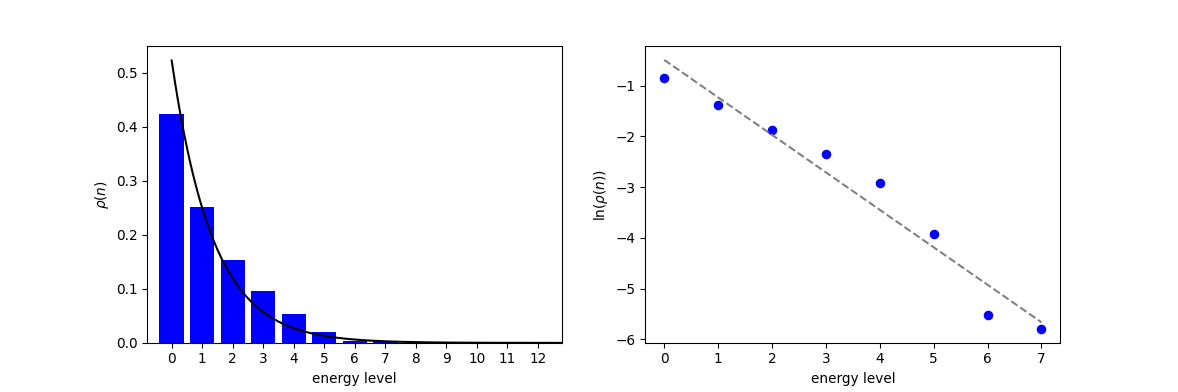

In [19]:
%matplotlib notebook
plot_prob_temp(dist_sum, nop, max_level)
plt.savefig('Boltzmann.pdf')

In [96]:
#task 4 auxiliary function
with open('Eav_temp.txt', 'w') as fh:
    print('#step\t' + '  ' + 'E_av\t\t', 'Temp', file=fh)
    for i, x, y in zip(np.arange(len(all_uav[nseqv:])), all_uav[nseqv:], all_temp[nseqv:]):
        print('%d\t' %(i), '%.4e\t'%(x*h*c*nu), '%.2f' %(y*((h*c*nu)/k_B)), file=fh)#units!!!!!

In [83]:
#task 6
for i, x, y in zip(np.arange(len(all_wbolt[:10])), all_wbolt[:10], all_sw[:10]):#make into function, 
    print('step %d\t' %(i), 'W = %6s\t' %(x), 'S_w = %.4fe-21 J/K' %(y*1e21))

step 0	 W =   90.0	 S_w = 0.0621e-21 J/K
step 1	 W =   90.0	 S_w = 0.0621e-21 J/K
step 2	 W =   90.0	 S_w = 0.0621e-21 J/K
step 3	 W =   90.0	 S_w = 0.0621e-21 J/K
step 4	 W =  360.0	 S_w = 0.0813e-21 J/K
step 5	 W =  360.0	 S_w = 0.0813e-21 J/K
step 6	 W =  720.0	 S_w = 0.0908e-21 J/K
step 7	 W =   90.0	 S_w = 0.0621e-21 J/K
step 8	 W =  720.0	 S_w = 0.0908e-21 J/K
step 9	 W = 2520.0	 S_w = 0.1081e-21 J/K


In [76]:
#task 7
nop = 10
levels = [0, 2, 3, 0, 0, 0, 0, 0, 0, 0]
W, S_w = calc_Bolt_ent(nop, levels)

print('Statistical weight: %.0f' %(W) + '    ' + 'Boltzmann entropy: %.4fe-21 J/K' %(S_w*1e21))#make into function

Statistical weight: 302400    Boltzmann entropy: 0.1742e-21 J/K
